In [ ]:
# Step 1: Install Necessary Libraries
!pip install pyspark
!pip install findspark

In [ ]:
# Step 2: Import Libraries and Initialize SparkSession
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, avg, round, desc
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize SparkSession
spark = SparkSession.builder.appName("CustomerChurnAnalysis").getOrCreate()

In [ ]:
# Step 3: Load and Explore the Dataset
from google.colab import files
uploaded = files.upload()

data_path = '/content/telecom_churn.csv'
data = spark.read.csv(data_path, header=True, inferSchema=True)

data.printSchema()
data.show(5)

print("Checking for null values:")
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

duplicates_count = data.count() - data.distinct().count()
print(f"Number of duplicates: {duplicates_count}")

data = data.distinct()

print("Summary statistics:")
data.describe().show()

Saving telecom_churn.csv to telecom_churn.csv
root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullabl

In [ ]:
# Step 4: Data Transformation
data = data.withColumn(
    "Day Usage Category",
    when(col("Total day minutes") > 250, "High")
    .when(col("Total day minutes") > 150, "Medium")
    .otherwise("Low")
)

data = data.withColumn("Churn", when(col("Churn") == True, "Yes").otherwise("No"))

categorical_cols = ['State', 'International plan', 'Voice mail plan', 'Churn']
numerical_cols = ['Account length', 'Number vmail messages', 'Total day minutes',
                  'Total day calls', 'Total eve minutes', 'Total eve calls',
                  'Total night minutes', 'Total night calls', 'Total intl minutes',
                  'Total intl calls', 'Customer service calls']

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_cols]

assembler = VectorAssembler(
    inputCols=numerical_cols + [f"{col}_index" for col in categorical_cols[:-1]],
    outputCol="features"
)

from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers + [assembler])
data_transformed = pipeline.fit(data).transform(data)

final_data = data_transformed.select("features", col("Churn_index").alias("label"))


In [ ]:
# Step 5: Model Building and Evaluation
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxBins=60) #  maxBins=60 splitting the data into ranges

paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 50]).build()
#to test different configurations of hyperparameters.

cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy"),
    numFolds=2
)# to find best hyperparameters

cv_model = cv.fit(train_data)

predictions = cv_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.4f}")

predictions.select("features", "label", "prediction").show()

Test Accuracy: 0.8943
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(14,[0,2,3,4,5,6,...|  0.0|       0.0|
|[1.0,0.0,182.1,10...|  1.0|       0.0|
|[1.0,26.0,146.6,6...|  0.0|       0.0|
|[3.0,0.0,161.0,96...|  0.0|       0.0|
|[6.0,0.0,183.6,11...|  0.0|       0.0|
|[8.0,36.0,242.9,6...|  0.0|       0.0|
|[10.0,0.0,222.2,1...|  0.0|       0.0|
|[12.0,0.0,216.7,1...|  0.0|       0.0|
|[13.0,31.0,265.3,...|  0.0|       0.0|
|[15.0,0.0,121.1,1...|  0.0|       0.0|
|[15.0,0.0,135.2,1...|  0.0|       0.0|
|[16.0,0.0,110.0,9...|  0.0|       0.0|
|[16.0,0.0,153.2,6...|  0.0|       0.0|
|[16.0,0.0,209.5,8...|  0.0|       0.0|
|[18.0,0.0,273.6,9...|  0.0|       0.0|
|[20.0,0.0,190.0,1...|  0.0|       0.0|
|[21.0,19.0,132.7,...|  0.0|       0.0|
|[25.0,0.0,242.6,6...|  0.0|       0.0|
|[28.0,0.0,121.7,4...|  1.0|       1.0|
|[28.0,0.0,187.8,9...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 2

In [ ]:
# Step 6: Feature Importance
rf_model = cv_model.bestModel
feature_importances = rf_model.featureImportances.toArray()

# Map feature names to importance scores
features = numerical_cols + [f"{col}_index" for col in categorical_cols[:-1]]
feature_imp_df = spark.createDataFrame(
    [(features[i], float(feature_importances[i])) for i in range(len(features))],
    ["Feature", "Importance"]
)

print("Feature Importance:")
feature_imp_df.orderBy("Importance", ascending=False).show()

Feature Importance:
+--------------------+--------------------+
|             Feature|          Importance|
+--------------------+--------------------+
|   Total day minutes|  0.3049707907346171|
|Customer service ...| 0.19536337220658762|
|         State_index| 0.13350152549006564|
|International pla...| 0.10689796839241429|
|    Total intl calls|0.054515562577584546|
|   Total eve minutes| 0.04224031993591312|
|  Total intl minutes| 0.04165578998650186|
|Voice mail plan_i...| 0.03903816577330239|
|Number vmail mess...|0.027035314188607606|
| Total night minutes|0.017494106186667177|
|   Total night calls|0.010886687196316126|
|      Account length| 0.00997378309957483|
|     Total day calls| 0.00974362291504901|
|     Total eve calls| 0.00668299131679878|
+--------------------+--------------------+



In [ ]:
# Step 7: Additional Analysis
churn_distribution = data.groupBy("Churn").count()
churn_distribution.show()

service_calls_churn = data.groupBy("Customer service calls", "Churn").count().orderBy(desc("count"))
service_calls_churn.show()

day_minutes_churn = data.groupBy("Day Usage Category", "Churn").count().orderBy(desc("count"))
day_minutes_churn.show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 2850|
|  Yes|  483|
+-----+-----+

+----------------------+-----+-----+
|Customer service calls|Churn|count|
+----------------------+-----+-----+
|                     1|   No| 1059|
|                     2|   No|  672|
|                     0|   No|  605|
|                     3|   No|  385|
|                     1|  Yes|  122|
|                     0|  Yes|   92|
|                     4|   No|   90|
|                     2|  Yes|   87|
|                     4|  Yes|   76|
|                     3|  Yes|   44|
|                     5|  Yes|   40|
|                     5|   No|   26|
|                     6|  Yes|   14|
|                     6|   No|    8|
|                     7|  Yes|    5|
|                     7|   No|    4|
|                     9|  Yes|    2|
|                     8|   No|    1|
|                     8|  Yes|    1|
+----------------------+-----+-----+

+------------------+-----+-----+
|Day Usage Category|Churn|coun

In [ ]:
# Step 8: Save the Model
model_path = "/content/customer_churn_rf_model"
cv_model.bestModel.write().overwrite().save(model_path)
print(f"Model saved to {model_path}")

Model saved to /content/customer_churn_rf_model


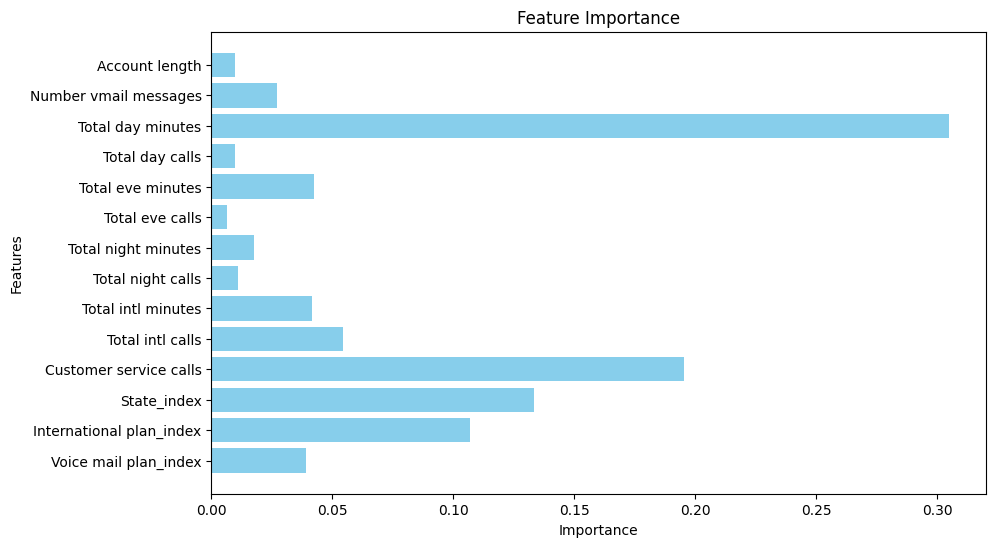

In [ ]:
# Step 9: Visualizations
import matplotlib.pyplot as plt

# Convert feature importance to Pandas for plotting
importances = feature_imp_df.toPandas()
plt.figure(figsize=(10, 6))
plt.barh(importances["Feature"], importances["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()